## Assignment #6. Beating baselines in "How good is your Medium article?"
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article)
Baseline achieved: **1.42869**
___
### Pursuit#1




In [3]:
import os
import json
from tqdm import tqdm_notebook, tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [6]:
PATH_TO_DATA = 'data/' # modify this if you need to

# Feature engineering
___

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [4]:
import clean

In [116]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data, 'generated',
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm(inp_json_file):
            json_data = read_json_line(line)

            for key, file in zip(features, feature_files):
                if key == 'content':
                    file.write(clean.cleaning(strip_tags(
                        json_data[key].replace('\n', ' ').replace('\r', ' ')))+'\n')
                elif key == 'published':
                    file.write(list(json_data[key].values())[0]+'\n')
                elif key == 'author':
                    file.write(json_data[key]['url'] + '\n')
                elif key == 'title':
                    file.write(clean.cleaning(
                        json_data[key].replace('\n', ' ').replace('\r', ' '))+'\n')
                else:
                    file.write(json_data[key]+'\n')

        map(lambda file: file.close(), feature_files)
        

In [48]:
with open('data/train.json') as f:
    for i in range(2):
        jsond = read_json_line(f.readline())

In [124]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

62313it [06:09, 168.83it/s]


In [117]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

34645it [03:21, 171.66it/s]


**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

#### Datetime features

In [126]:
X_datetime_train = pd.read_csv('data/generated/train_published.txt', 
            names=['datetime','b'], 
            parse_dates=['datetime'])[['datetime']]
X_datetime_test = pd.read_csv('data/generated/test_published.txt', 
            names=['datetime','b'], 
            parse_dates=['datetime'])[['datetime']]

X_datetime_train.shape, X_datetime_test.shape

((62313, 1), (34645, 1))

In [127]:
def add_datetime_features(df):
    hour = df.datetime.apply(lambda time: time.hour)
    weekday = df.datetime.apply(lambda date: date.dayofweek)
    weekend = (weekday.isin([5,6]))
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
#     X = hstack([hour.values.reshape(-1, 1),
#                 weekend.values.reshape(-1,1),
#                 morning.values.reshape(-1,1),
#                 day.values.reshape(-1,1),
#                 evening.values.reshape(-1,1),
#                 night.values.reshape(-1,1)])
    return csr_matrix(np.hstack([hour.values.reshape(-1,1),
                weekend.values.reshape(-1,1),
                morning.values.reshape(-1,1),
                day.values.reshape(-1,1),
                evening.values.reshape(-1,1),
                night.values.reshape(-1,1)]))

In [128]:
X_datetime_train_sparse = add_datetime_features(X_datetime_train)
X_datetime_test_sparse = add_datetime_features(X_datetime_test)

#### Author features

In [129]:
def getnick(path):
    return os.path.basename(os.path.normpath(path))

In [130]:
X_authors_train = pd.read_csv(open('data/generated/train_author.txt'), 
                        names=['url']).url.apply(getnick)
X_authors_test = pd.read_csv(open('data/generated/test_author.txt'), 
                        names=['url']).url.apply(getnick)

In [131]:
X_authors_train.shape, X_authors_test.shape

((62313,), (34645,))

In [132]:
ohe = OneHotEncoder(handle_unknown='ignore')  # Ignore unknown authors in test
X_authors_train_ohe = ohe.fit_transform(X_authors_train.values.reshape(-1, 1))
X_authors_test_ohe = ohe.transform(X_authors_test.values.reshape(-1, 1))

#### Title and Content features

In [133]:
tf_idf_word = TfidfVectorizer(ngram_range=(1,2), analyzer='word',
                              max_features=100000, stop_words='english',
                              sublinear_tf=True, strip_accents='unicode')

tf_idf_char = TfidfVectorizer(ngram_range=(1,4), analyzer='char', 
                              max_features=5000, strip_accents='unicode')

In [134]:
%%time
with open('data/generated/train_title.txt') as input_file:
    X_title_train_tfidfword = tf_idf_word.fit_transform(input_file)
with open('data/generated/train_title.txt') as input_file:
    X_title_train_tfidfchar = tf_idf_char.fit_transform(input_file)

with open('data/generated/test_title.txt') as input_file:
    X_title_test_tfidfword = tf_idf_word.transform(input_file)
with open('data/generated/test_title.txt') as input_file:
    X_title_test_tfidfchar = tf_idf_char.transform(input_file)


CPU times: user 16.6 s, sys: 618 ms, total: 17.2 s
Wall time: 15.6 s


In [137]:
X_title_train_tfidfchar.shape, X_title_test_tfidfchar.shape

((62313, 5000), (34645, 5000))

In [144]:
X_title_train_tfidf = hstack([X_title_train_tfidfword, X_title_train_tfidfchar])
X_title_test_tfidf = hstack([X_title_test_tfidfword, X_title_test_tfidfchar])

In [143]:
%%time
with open('data/generated/train_content.txt') as input_file:
    X_content_train_tfidfword = tf_idf_word.fit_transform(input_file)
with open('data/generated/train_title.txt') as input_file:
    X_content_train_tfidfchar = tf_idf_char.fit_transform(input_file)

with open('data/generated/test_content.txt') as input_file:
    X_content_test_tfidfword = tf_idf_word.transform(input_file)
with open('data/generated/test_content.txt') as input_file:
    X_content_test_tfidfchar = tf_idf_char.transform(input_file)

CPU times: user 15min 3s, sys: 33.8 s, total: 15min 37s
Wall time: 15min 39s


In [145]:
X_content_train_tfidfword.shape, X_content_test_tfidfword.shape

((62313, 100000), (34645, 100000))

In [146]:
X_content_train_tfidf = hstack([X_content_train_tfidfword, X_content_train_tfidfchar])
X_content_test_tfidf = hstack([X_content_test_tfidfword, X_content_test_tfidfchar])

**Join all sparse matrices.**

In [147]:
X_train_sparse = hstack([X_content_train_tfidf, X_title_train_tfidf,
                         X_datetime_train_sparse, X_authors_train_ohe]).tocsr()
X_test_sparse = hstack([X_content_test_tfidf, X_title_test_tfidf,
                        X_datetime_test_sparse, X_authors_test_ohe]).tocsr()

In [150]:
import scipy

In [151]:
scipy.sparse.save_npz('data/generated/X_train_sparse', X_train_sparse)
scipy.sparse.save_npz('data/generated/X_test_sparse', X_test_sparse)

In [155]:
X_train_sparse.shape, X_test_sparse.shape

((62313, 241546), (34645, 241546))

In [4]:
X_train_sparse = load_npz('data/generated/X_train_sparse.npz')
X_test_sparse = load_npz('data/generated/X_test_sparse.npz')

# Training and Validating
___

**Read train target and split data for validation.**

In [7]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [8]:
train_part_size = int(0.7 * train_target.shape[0])

X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]

X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

#### Baseline

In [273]:
ridge_regr = Ridge()
ridge_regr.fit(X_train_part_sparse, y_train_part)
mean_absolute_error(y_valid, ridge_regr.predict(X_valid_sparse))

1.0700332344177363

#### Enchanced trainset

In [ ]:
ridge_regr = Ridge(random_state=42)
ridge_regr.fit(X_train_part_sparse, y_train_part)
mean_absolute_error(y_valid, ridge_regr.predict(X_valid_sparse))

In [20]:
mean_absolute_error(y_valid, ridge_regr.predict(X_valid_sparse))

1.0651077361722514

In [20]:
mean_absolute_error(y_valid, ridge_regr.predict(X_valid_sparse))

1.0651077361722514

#### Try RidgeCV

In [37]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
alphas = np.logspace(-2, 6, 10)
ridge = Ridge(random_state=42)

In [15]:
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.001}

In [41]:
params = {'alpha': np.logspace(-2, 2, 30)}

In [42]:
%%time
grid = GridSearchCV(ridge, param_grid=params,
                    scoring='neg_mean_absolute_error',
                    cv=kf, n_jobs=-1, verbose=1)
grid.fit(X_train_part_sparse, y_train_part)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 35.8min finished


CPU times: user 1min 57s, sys: 2.49 s, total: 1min 59s
Wall time: 37min 47s


In [44]:
mean_absolute_error(y_valid, grid.predict(X_valid_sparse))

1.0679162227333658

In [43]:
grid.best_estimator_

Ridge(alpha=0.17433288221999882, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=42, solver='auto',
   tol=0.001)

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [21]:
%%time
y_submit = ridge_regr.fit(X_train_sparse, y_train).predict(X_test_sparse)

CPU times: user 2min 31s, sys: 4.14 s, total: 2min 35s
Wall time: 2min 36s


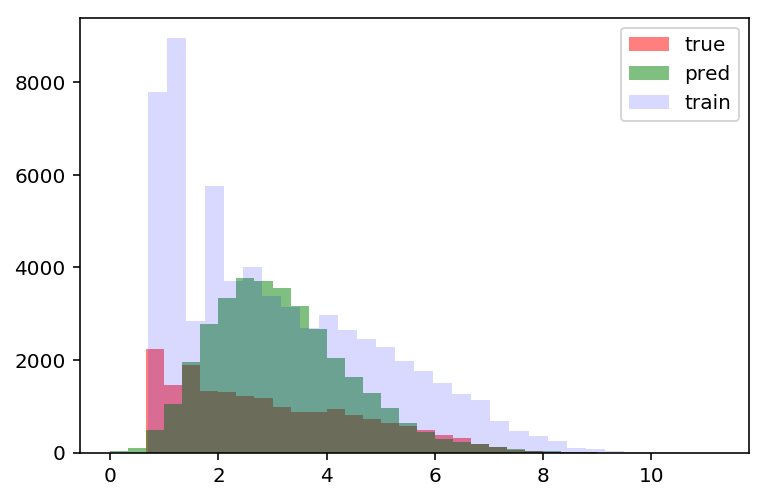

In [22]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(y_submit, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.hist(y_train, bins=30, alpha=.15, color='blue', label='train')

plt.legend();

In [23]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [24]:
write_submission_file(y_submit, os.path.join(PATH_TO_DATA,
                                                    'assignment6_medium_submission_pursuit_1.csv'))

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [286]:
write_submission_file(np.zeros_like(y_submit), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [32]:
y_submit.mean()

3.1572841440288566

In [31]:
mean_right = 4.33328

diff = mean_right - y_submit.mean()

diff

1.1759958559711436

In [33]:
ridge_test_pred_modif = y_submit + diff # You code here

In [34]:
write_submission_file(ridge_test_pred_modif, 
                      os.path.join(PATH_TO_DATA,
                                   'assignment6_medium_submission_pursuit_1_with_hack.csv'))

That's it for the assignment. Much more credits will be given to the winners in this competition, check [course roadmap](https://mlcourse.ai/roadmap). Do not spoil the assignment and the competition - don't share high-performing kernels (with MAE < 1.5).

Some ideas for improvement:

- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used C=1 as a regularization parameter, this can be changed
- SGD and Vowpal Wabbit will learn much faster
- Play around with blending and/or stacking. An intro is given in [this Kernel](https://www.kaggle.com/kashnitsky/ridge-and-lightgbm-simple-blending) by @yorko 
- In our course, we don't cover neural nets. But it's not obliged to use GRUs/LSTMs/whatever in this competition.

Good luck!
